In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import numpy as np
from qiskit import transpile
from qiskit_ibm_runtime import Session, Estimator, QiskitRuntimeService, Options
from qiskit.quantum_info import Operator, Statevector

from nonlocalgames.hamiltonians import G14
from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz
from nonlocalgames.measurement import MeasurementLayer

2023-09-15 11:50:12,436	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [3]:
def get_pcc() -> Operator:
    proj = 0
    for c in range(4):
        s = f'{c:02b}'[::-1]
        s = s + s
        cc = Statevector.from_label(s)
        pcc = cc.to_operator()
        proj += pcc
    
    return proj

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False,
        min_theta = 1e-4)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    constrained = False
    if 'constrained' in path:
        constrained = True

    if 'metadata' in data:
        layer = data['metadata'].get('layer', 'ry')
        constrained = data['metadata'].get('constrain_phi', constrained)
    else:
        layer = 'ry'
    
    ml = MeasurementLayer.get(layer, players=2, questions=14, qubits=2)
    
    if constrained:
        if phi.ndim == 1:
            phi = np.concatenate([phi, phi]).reshape(ml.shape)
        else:
            phi = np.concatenate([phi, phi])
            assert phi.shape == ml.shape
    
    ml.params = phi

    if constrained:
        ml.conj(1)

    return qc, ml

In [4]:
qc, ml = load_g14_circuit('../../data/g14_constrained_u3ry/g14_state.json')
nlg = NLGCircuit(qc, None, measurement_layer=ml)

vertices = [(v, v) for v in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges

pcc = get_pcc()
pcc.dim

(16, 16)

In [10]:
import tqdm

options = Options()
options.execution.shots = 1024
options.optimization_level = 3
options.resilience_level = 2  # ZNE
options.resilience.noise_factors = [1, 2, 3, 4, 5]
# options.resilience.noise_amplifier = "LocalFoldingAmplifier"

dev = 'ibm_hanoi'
service = QiskitRuntimeService(name='full')
backend = service.get_backend(dev)

In [ ]:

with Session(service=service, backend=backend) as session:
    nlg.backend = backend
    estimator = Estimator(session=session, options=options)
    circuits = []
    for q in tqdm.tqdm(questions):
        circuit = nlg._prepare_question(q)
        circuit.remove_final_measurements()
        circuits.append(circuit)
    observables = [pcc] * len(circuits)

    job = estimator.run(circuits=circuits, observables=observables)
    print('Job:', job.job_id())
    result = job.result()

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(name='full')
job = service.job('ck26igqdijuadepmgdgg')
result = job.result()
backend = job.backend()
dev = backend.name

In [11]:
basepath = 'zne_results_optim{optim}_zne{zne}_{dev}'.format(
            optim=options.optimization_level,
            zne=options.resilience_level,
            dev=dev
        )
metadata = result.metadata
values = result.values.tolist()
for m, q in zip(metadata, questions):
    m['question'] = q
with open(f'{basepath}.json', 'w', encoding='utf-8') as f:
    json.dump({
        'metadata': result.metadata,
        'values': result.values.tolist()
    }, f)

In [12]:
import pandas as pd

records = []

for m, zne_value in zip(metadata, values):
    zne_data = m['zne']['noise_amplification']
    for noise_level, obs_value, obs_var in zip(
        zne_data['noise_factors'],
        zne_data['values'],
        zne_data['variance']):

        records.append({
            'va': m['question'][0],
            'vb': m['question'][1],
            'noise_factor': noise_level,
            'obs_value': obs_value,
            'obs_var': obs_var,
            'extrapolated_value': zne_value
        })

df = pd.DataFrame.from_records(records)
df.sort_values(['va', 'vb'], inplace=True)
df.to_csv(f'{basepath}.csv', index=False)
df

,va,vb,noise_factor,obs_value,obs_var,extrapolated_value
0,0,0,1,0.488281,0.129309,0.536621
1,0,0,2,0.884766,0.051594,0.536621
2,0,0,3,0.933594,0.031575,0.536621
3,0,0,4,0.971680,0.013816,0.536621
4,0,0,5,0.964844,0.017103,0.536621
...,...,...,...,...,...,...
65,13,13,1,0.937500,0.029713,0.929199
66,13,13,2,0.934570,0.030850,0.929199
67,13,13,3,0.974609,0.012436,0.929199
68,13,13,4,0.966797,0.016195,0.929199


## Postprocessing

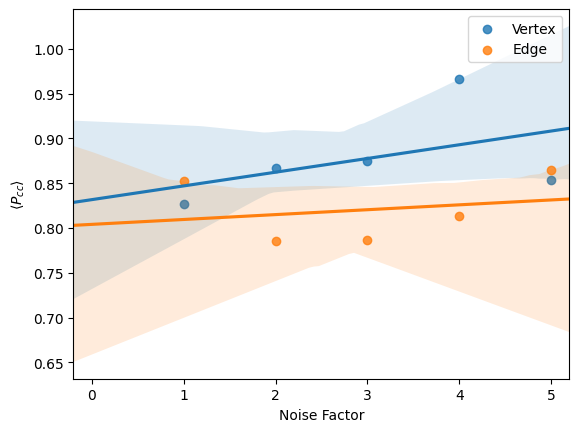

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process(df):
    df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')
    df['post_obs_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.obs_value,
        df.obs_value
    )
    df['post_extrapolated_value'] = np.where(
        df.qtype == 'Edge',
        1 - df.extrapolated_value,
        df.extrapolated_value
    )

    return df

dev = 'ibm_hanoi'
df = pd.read_csv(f'zne_results_optim3_zne2_{dev}.csv')
df = process(df)
fig = plt.figure()
ax = fig.gca()
plt.xlim(-0.2, 5.2)
for i, qtype in enumerate(df.qtype.unique()):
    sns.regplot(
        ax=ax,
        data=df.loc[df.qtype == qtype].groupby('noise_factor').mean(numeric_only=True).reset_index(),
        x='noise_factor',
        y='obs_value',
        color=f'C{i}',
        label=qtype,
        marker='o',
        truncate=False
    )
plt.xlabel('Noise Factor')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.ylabel(r'$\langle P_{cc} \rangle$')
plt.legend()
plt.show()

We get a much different result using the `simulator_statevector` device..

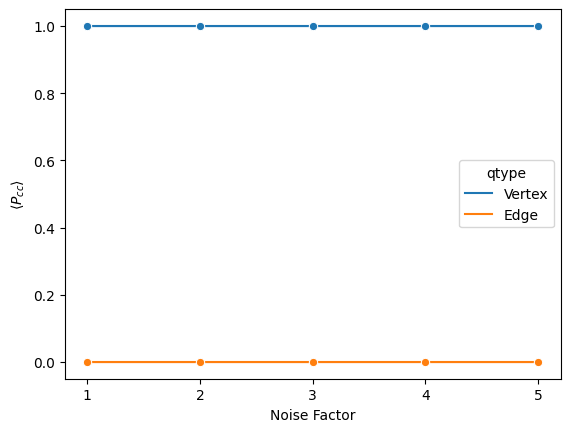

In [15]:
dev = 'simulator_statevector'
df = pd.read_csv(f'zne_results_optim3_zne2_{dev}.csv')

df = process(df)
sns.lineplot(
    data=df,
    x='noise_factor',
    y='obs_value',
    hue='qtype',
    marker='o'
)
plt.xlabel('Noise Factor')
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.ylabel(r'$\langle P_{cc} \rangle$')
plt.show()